In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, tqdm_notebook
from torch.utils.data import DataLoader,Dataset
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
train_data=pd.read_csv('./dataset/updated_train.csv')

In [3]:
"""The posts which dont have a body have nan token replacing that with 0"""
train_data=train_data.fillna(0)

## Body
Checking the Size of The body of Posts

Posts analysis it is found that the average(429.07) and largest(14750) are extremely large passing it through a RNN Model or LSTM would be extremely expensive. So either it needs to be truncated or Linear models like fastText needs to be used

In [4]:
"""Checking the length of body size"""
lenr=[]
for i in range(train_data.shape[0]):
    if train_data.loc[i,'Body']!=0:
        #print(train.loc[i,'Body'])
        lenr.append(len(train_data.loc[i,'Body']))
print(max(lenr),sum(lenr)/len(lenr))

14750 429.0718816067653


In [5]:
train_data.head()

,Unnamed: 0,index,idx,Title,Score,ID,Image,Num_Comments,Created,Body,Label1Coronovirus,Label2Politics,Label3Non-Political,Label4Objects,Label5AskIndia
0,0,0,0,Coronavirus (COVID-19) Megathread - News and U...,287,fqqdsg,https://www.reddit.com/r/india/comments/fqqdsg...,6834,1.585451e+09,**Central thread for sharing coronavirus News ...,1,0,0,0,0
1,1,1,1,Firozabad police fact-checking zee news (trans...,680,fwcz7h,https://i.redd.it/jbal4gxocbr41.jpg,62,1.586258e+09,0,0,1,0,0,0
2,2,2,2,Donald Trump talks of ‘retaliation’ if India t...,371,fwclvi,https://economictimes.indiatimes.com/industry/...,135,1.586257e+09,0,1,0,0,0,0
3,3,3,3,Mom came up with this impressive idea to celeb...,3129,fvz69t,https://i.redd.it/gurfdfd1e7r41.jpg,183,1.586210e+09,0,0,0,1,0,0
4,4,4,4,9 PM 9 Minutes: House Catches Fire In Bihar; G...,181,fwdysc,https://news.abplive.com/news/india/coronaviru...,14,1.586262e+09,0,0,0,1,0,0


# Title and Body Data
The CountVectorizer takes in data in the format list(list())  

In [6]:
title=list(train_data['Title'])
body=list(train_data['Body'])
#score=list((train_data['Num_Comments'],train_data['Score']))
#label=list([train_data['Label1Coronovirus'],train_data['Label2Politics'],train_data['Label3Non-Political'],train_data['Label4Objects'],train_data['Label5AskIndia']])

## Score and Label Data
### Number of Comments and Score
In addition to  body and title, I decided to use the number of comments and score, as seen in the EDA file, there is significant variation amongst the different flairs for these variables.
These to are in the form a list for each point hence forming a list of lists

### Label
The labels are also converted in the form of a list of list

In [7]:
scores=[]
labels=[]
for i in range(train_data.shape[0]):
    scores.append((train_data.loc[i,'Num_Comments'],train_data.loc[i,'Score']))
    labels.append([train_data.loc[i,'Label1Coronovirus'],train_data.loc[i,'Label2Politics'],train_data.loc[i,'Label3Non-Political'],train_data.loc[i,'Label4Objects'],train_data.loc[i,'Label5AskIndia']])

# Preprocessing Applied
The Text has to preprocessed and broken into indiviual tokens from sentences before they can be embedded or sent to a model
## 1. Tokenisation
-Done using spacy tokeniser. Better to use this rather than normal .split() method
as it seperates punctuation attached to words like the what is (what?) and (what)
would have been treated differently in .split method, but not with spacy
## 2. Lemmatisation
-Also using Spacy, basically converts some word which are derived from otherwords to their root word. Like sleeping is converted to sleep.
## 3. Punctuation Removal
-String class of python provides a list of all punctuations. Insteead of removing all punctuations, I decided to keep '?' as I think it does add some value in deciding the flair 

In [8]:
import string
k=string.punctuation

punct=[]
for i in range(len(k)):
    if(k[i]=='?'):
        continue
    else: 
        punct.append(k[i])

In [9]:
#!pip install unidecode
import nltk
import spacy
import unidecode
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

In [10]:
spacy_eng=spacy.load('en')
nlp=spacy.load("en_core_web_sm")
def tokenize_eng(text):
    sent=[]
    lema=nlp(text)
    for tok in spacy_eng.tokenizer(text):
        
        word=tok.lemma_
        #word=tok.text
        
        if word not in punct:
            if word not in stop:
                word=unidecode.unidecode(word)
                if(word!=word.split('_')[0]):
                    sent.extend(word.split('_'))
                else:
                    sent.append(word)
    
    return sent

In [11]:
a='covid19gujarate'
c=[]
d=[]
for word in a.split():
    c.append(word)
    print(word.split('_')[0])
    
    d.extend(word.split('_'))

covid19gujarate


In [12]:
c,d

(['covid19gujarate'], ['covid19gujarate'])

In [13]:
tokenize_eng('covid 19 gujarate')

['covid', '19', 'gujarate']

Passing the Body and Title through the tokenization function. They are not done in one step as it exceeds the memory.

In [14]:
for i in range(len(body)):
    
    body[i]=' '.join(tokenize_eng(body[i]))

In [15]:
for i in range(len(title)):
    
    title[i]=' '.join(tokenize_eng(title[i]))

Example of Tokenised Data

In [16]:
sent=train_data.loc[2,'Title']
sent_=tokenize_eng(sent)
print(f"Tokenised {sent_}")
print(f"Original  {[sent]}")

Tokenised ['Donald', 'Trump', 'talk', "'", 'retaliation', "'", 'India', 'turn', 'Covid', 'drug', 'request']
Original  ['Donald Trump talks of ‘retaliation’ if India turns down Covid drug request']


# Dataset Class
To pass data through an iterator/convert to batches the dataset needs to be converted into this format. 


Takes the title data,body data, score data and labels
The text datasets (context and title) need to be in the format list(list())

A vocabulary is created using Countvectorizer method of PyTorch.
Using this vocab, each word is numericalised

Returns numericalised numpy arrays for all inputs in the form of tuple.



In [17]:
class Dataset(Dataset):
    def __init__(self,data_title,data_context,data_score,labels):
        
        self.vectorizer=CountVectorizer()
        
        self.vectorizer.fit_transform(data_context+data_title)
        
        self.token2idx=self.vectorizer.vocabulary_
        
        #Numericalising Titles
        self.sequences=[]
        self.sequences_context=[]
        for sent in data_title:
            sent_brok=[]
            
            for word in sent.split():
                try:
                
                    sent_brok.append(self.token2idx[word])
                except KeyError:
                    sent_brok.append('0')
            self.sequences.append(sent_brok)
        
        #Same for Context
        for sent in data_context:
            sent_brok=[]
            
            for word in sent.split():
                try:
                    
                    sent_brok.append(self.token2idx[word])
                except KeyError:
                    sent_brok.append('0')
            self.sequences_context.append(sent_brok)
        
        #self.sequences_context=[self.token2idx[word] for word in data_context]
        self.score=data_score
        self.labels=labels
        
        
        self.idx2token={idx:token for token,idx in self.token2idx.items()}
        
    def __getitem__(self,i):
        return np.array(self.sequences[i],dtype=int),np.array(self.sequences_context[i],dtype=int),np.array(self.score[i],dtype=int),np.array(self.labels[i],dtype=int)
    
    def __len__(self):
        return len(self.sequences)

In [19]:
dataset=Dataset(data_title=title,
               data_context=body,
               data_score=scores,
               labels=labels)

In [20]:
dataset[0][1].shape

(912,)

In [21]:
len(dataset.vectorizer.vocabulary_)

5731

# Vocabulary
The vocab of sklearn vectorizer can be accessed as vectorizer.vocabulary_
It is a dictionary mapping words to numerical value
Saving the Pretrained vocab to be used for testing also 

In [22]:
torch.save(dataset.vectorizer.vocabulary_,'vocab_')

# Word Embedding
Here I decided to use GloVe 50d embedding as the 300d dim is a bit to large and the embedding matrix may become too large to upload on cloud.

The GloVe file has a structure of word followed by its embedding matrix. 
Since the vocabulary has 400,000 words I decided to bcolz to store array of vectors. Since it is based on numpy only there is no need to interconvert.  


### Bcolz 
It is a form of storing data in columnar,chunked format in containers. It is based on numpy only
https://github.com/Blosc/bcolz

In [23]:
#!pip install bcolz
import bcolz

In [24]:
words=[]
idx=0
word2idx={}
import pickle
vectors=bcolz.carray(np.zeros(1),rootdir=f'../glove.6B.50d.dat',mode='w')
with open(f'../glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)

vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir=f'../glove.6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words,open(f'../glove.pkl','wb'))
pickle.dump(word2idx,open(f'../glove_dict.pkl','wb'))


# Dictionary
Using those objects we can now create a dictionary to reference word given word

In [25]:
vectors = bcolz.open(f'../glove.6B.50.dat')[:]
words = pickle.load(open(f'../glove.pkl', 'rb'))
word2idx = pickle.load(open(f'../glove_dict.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [26]:
"""The original word to token matching dictionary can be accessed like this"""
#dataset.vectorizer.vocabulary_

'The original word to token matching dictionary can be accessed like this'

# Applying the Dataset
For all the words present in dictionary converting them to their embedding, and for those not present inserting a row of normally distributed random numbers instead of zeros. These values can change during backprop if weights not frozen.

In [27]:
matrix_len=len(dataset.vectorizer.vocabulary_)
weight_matrix=np.zeros((matrix_len,50))
words_found=0

for i, word in enumerate(dataset.vectorizer.vocabulary_):
    try:
        weight_matrix[i]=glove[word]
        words_found+=1
        
    except KeyError:
        weight_matrix[i]=np.random.normal(scale=0.6,size=(50,))

In [28]:
"""This matrix (Embedding matrix) should have a shape [Vocab_size , Emebedding_dim]"""
weight_matrix.shape

(5731, 50)

## Pretrained vectors of Embedding
The weights of embedding will be copied to nn.Embedding layer and weights will be frozen

In [29]:
#pretrained_vecs=torch.load('pretrained_wts')
pretrained_vecs=torch.tensor(weight_matrix)

In [30]:
torch.save(pretrained_vecs,'pretrained_wts')

# Model

### Title Model
In this model I have used a BiLSTM for the Title and applied self attention(attention between last hidden state and each hidden state of the encoder)
To give importance to the usefull key words. This output is concatenated with the actual final hidden state as that is sort of the summary of the whole sentence.

### Number of Comments and Score
In addition to this the number of comments and score are also passed through a feed forward network and concatenated with the output of Title model

### Body
The output of the FastText model for Body is also conatenated with the output of the above 2 after using self attention with the final hidden state, to extract key parts in the context, as the entire context is usually not usefull

Concatenation of all these is passed through the output layer and then Probabilities of flair is found using Softmax
To use NLL Loss Log Softmax is used instead of regular softmax

## Embedding Weights
The embedding layer is basically a look up table, gets its weights from the pretrained vectors. Here usually the weights are frozen and not finetuned. 

## Finetuning Weights
Since many words related to coronavirus like covid corona didn't exist during making of vocab, hence their vectors are zeros at start. Hence to make the model learn their weights I allowed finetuning. This helped model to recognize the similarity between such words and not treat them as 0s.

In [31]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Model(nn.Module):
    def __init__(self,n_vocab,
                 pretrained_vec,
                batch_size=16,
                embedding_dim=50,
                hidden_dim=64,
                num_layer=2,
                 dropout=0.3,
                 output_dims=5,
                 second_output=16,
                bidirectional=True):
        super(Model,self).__init__()
        self.n_vocab=n_vocab
        self.batch_size=batch_size
        self.embedding_dim=embedding_dim
        self.hidden_dim=hidden_dim
        self.num_layer=num_layer
        self.bidirectional=bidirectional
        self.dropout=dropout
        
        self.output_dims=output_dims
        
        self.embedding=nn.Embedding(n_vocab,embedding_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        #self.embedding.weight.requires_grad=False
        
        self.second_output=nn.Linear(2,16)
        
        self.rnn=nn.LSTM(self.embedding_dim, self.hidden_dim,
                       num_layers=self.num_layer,
                       batch_first=True,bidirectional=self.bidirectional,
                        dropout=0.5)
        
       
        self.fc1=nn.Linear(hidden_dim*6+16,self.output_dims)
        
        self.dropout=nn.Dropout(dropout)
        self.logsoftmax=nn.LogSoftmax()
        
    def apply_attention(self,final_hid, all_hid):
    #final hid dim [batch,seqlen]
        final_hid=final_hid.unsqueeze(2)
    
    #Final hid_dim [batch,1,SeqLen]
        attention_scores=torch.bmm(all_hid,final_hid).squeeze(2)
        soft_attention_weights=F.softmax(attention_scores).unsqueeze(2)
        
        attention_output=torch.bmm(all_hid.permute(0,2,1),soft_attention_weights).squeeze(2)
   
        return attention_output
    
    def forward(self,data,num_data,context=None):
        
        embedded=self.embedding(data)
        output,(hidden_,_)=self.rnn(embedded)
        hidden_=torch.cat((hidden_[-1,:,:],hidden_[-2,:,:]),dim=1)
        
        attention_output=self.apply_attention(final_hid=hidden_,all_hid=output)
        
        concat_vec=torch.cat([hidden_,attention_output],dim=1)
        hidden=self.dropout(concat_vec)
        
        num_output=self.dropout(self.second_output(num_data))
        hidden=torch.cat([hidden,num_output],dim=1)
        
        context=self.apply_attention(final_hid=hidden_,all_hid=context)
        hidden=self.dropout(torch.cat([hidden,context],dim=1))
        
        output=self.fc1(hidden)
        
        return output

In [32]:
class fastText(nn.Module):
    def __init__(self,vocab_size,embedding_dim,
                 hidden_size,output_size,pretrained_wv):
        super(fastText,self).__init__()
        self.embedding_dim=embedding_dim
        self.pretrainedwts=pretrained_wv
        self.output_size=output_size
        self.hidden_size=hidden_size
        self.dropout=nn.Dropout(0.4)
        
        
        #Embedding Layer
        self.embedding=nn.Embedding(vocab_size,embedding_dim)
        self.embedding.weight.data.copy_(self.pretrainedwts)
        self.embedding.weight.requires_grad=False
        
        self.fc1=nn.Linear(self.embedding_dim,self.hidden_size)
        
        self.fc2=nn.Linear(self.hidden_size,self.output_size)
        self.softmax=nn.Softmax()

    def forward(self,x):
        embedded=self.embedding(x)
        h=self.dropout(self.fc1(embedded))
        z=self.dropout(self.fc2(h))
        return self.softmax(z,)

In [33]:
embedding_dim=50
Input_Vocab=pretrained_vecs.shape[0]
model_context=fastText(vocab_size=Input_Vocab,
        embedding_dim=embedding_dim,
        hidden_size=128,
        output_size=256,
        pretrained_wv=pretrained_vecs)
print(model_context)

fastText(
  (dropout): Dropout(p=0.4, inplace=False)
  (embedding): Embedding(5731, 50)
  (fc1): Linear(in_features=50, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (softmax): Softmax(dim=None)
)


In [34]:
embedding_dim=50
hidden_dim=128
enc_dropout=0.5

Input_Vocab=pretrained_vecs.shape[0]

model=Model(n_vocab=Input_Vocab,pretrained_vec=pretrained_vecs,
            embedding_dim=embedding_dim,hidden_dim=hidden_dim,
            dropout=enc_dropout)

print(model)

Model(
  (embedding): Embedding(5731, 50)
  (second_output): Linear(in_features=2, out_features=16, bias=True)
  (rnn): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=784, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (logsoftmax): LogSoftmax()
)


# Training Loop

### Optimizer-
Adam- Combines advantages of Adaptive Gradient Algorithm and RMSProp
### Loss Function-
CrossEntropy loss with logsoftmax which is basically NLL Loss, which is on experimentation found to be better than BCE or BCEWithLogitsLoss

In [35]:
import tqdm
import torch.optim as optim
optimizer=optim.Adam(model.parameters())

optimizer_context=optim.Adam(model_context.parameters())
#criterion=nn.BCEWithLogitsLoss()
criterion=nn.CrossEntropyLoss()
EPOCH=2

In [39]:
epoch_loss_dat=[]
epoch_num_correct=[]

# Training Loop

## Optimizer-
Adam- Combines advantages of Adaptive Gradient Algorithm and RMSProp

## Loss Function-
CrossEntropy loss with logsoftmax which is basically NLL Loss, which is on experimentation found to be better than BCE or BCEWithLogitsLoss

### Num Corrects
To better undertand the performance of model, I decided to print the number of correctly predicted Flairs with each epoch. 

## Embedding Weights
The embedding layer's (nn.Embedding) were copieed from the weight matrix made using GloVe's and Corpus vocab. I decided to not freeze them as words like Coronavirus which were not included in GloVe, got a random distribution. These vectors need get updated.   

In [40]:
def train(model,model_context,train_iter):
    for epoch in range(1,20):
        running_loss=0.0
        running_corrects=0
        model.train()
        model_context.train()
        epoch_lo=0
        for x,x_context,x2,y in tqdm.tqdm(train_iter):
            
            x=torch.tensor(x).unsqueeze(0)
            #print(x.shape)
            x_context=torch.tensor(x_context).unsqueeze(0)
            #print(x_context.shape)
            x2=torch.tensor(x2).unsqueeze(0)
            #print(x2.shape)
            y=torch.tensor(y)
            
            optimizer.zero_grad()
            optimizer_context.zero_grad()
            
            
            context=model_context(x_context)
            preds=model(data=x,num_data=x2.float(),context=context)
            
            
            preds=preds.squeeze(0)
            
            #print(torch.max(y,0)[1].unsqueeze(0).shape)
            #print(preds.shape)
            
            loss=criterion(preds.unsqueeze(0),torch.max(y,0)[1].unsqueeze(0))
            
            epoch_lo+=(torch.max(preds,0)[1]==torch.max(y,0)[1]).sum()
            
            loss.backward()
            
            optimizer.step()
            optimizer_context.step()
            running_loss+=loss.item()
        epoch_loss=running_loss/train_data.shape[0]
        epoch_num_correct.append(epoch_lo)
        epoch_loss_dat.append(epoch_loss)
        print(f'Epoch :{epoch}, Training Loss: {epoch_loss}, Num_Correct={epoch_lo}')

In [41]:
train(model,model_context,dataset)

  0%|          | 0/473 [00:00<?, ?it/s]/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/473 [00:00<?, ?it/s]

Epoch :1, Training Loss: 5.652279573692416, Num_Correct=147


  0%|          | 1/473 [00:00<01:25,  5.52it/s]

Epoch :2, Training Loss: 4.928596152799018, Num_Correct=161


  0%|          | 2/473 [00:00<00:30, 15.64it/s]

Epoch :3, Training Loss: 6.0283024719593525, Num_Correct=164


  0%|          | 2/473 [00:00<00:33, 14.27it/s]

Epoch :4, Training Loss: 4.288272631326188, Num_Correct=194


  0%|          | 1/473 [00:00<00:52,  9.03it/s]

Epoch :5, Training Loss: 5.642298669650331, Num_Correct=199


  0%|          | 2/473 [00:00<00:37, 12.63it/s]

Epoch :6, Training Loss: 4.734444463455008, Num_Correct=239


  0%|          | 2/473 [00:00<00:32, 14.42it/s]

Epoch :7, Training Loss: 5.091314905111122, Num_Correct=257


  0%|          | 2/473 [00:00<00:39, 11.89it/s]

Epoch :8, Training Loss: 2.5777286233450267, Num_Correct=267


  0%|          | 2/473 [00:00<00:31, 14.81it/s]

Epoch :9, Training Loss: 2.309064956252812, Num_Correct=315


  0%|          | 2/473 [00:00<00:37, 12.57it/s]

Epoch :10, Training Loss: 6.256137743923786, Num_Correct=311


  0%|          | 2/473 [00:00<00:30, 15.24it/s]

Epoch :11, Training Loss: 2.7453870658138313, Num_Correct=336


  0%|          | 2/473 [00:00<00:34, 13.69it/s]

Epoch :12, Training Loss: 1.041091339735962, Num_Correct=365


  0%|          | 2/473 [00:00<00:33, 14.11it/s]

Epoch :13, Training Loss: 1.3229086292583665, Num_Correct=376


  0%|          | 2/473 [00:00<00:30, 15.31it/s]

Epoch :14, Training Loss: 2.0632292128472898, Num_Correct=378


  0%|          | 2/473 [00:00<00:28, 16.42it/s]

Epoch :15, Training Loss: 1.848329278855734, Num_Correct=385


  0%|          | 2/473 [00:00<00:40, 11.70it/s]

Epoch :16, Training Loss: 0.8578632393510907, Num_Correct=396


  0%|          | 2/473 [00:00<00:28, 16.58it/s]

Epoch :17, Training Loss: 0.9890670783904653, Num_Correct=393


  0%|          | 2/473 [00:00<00:30, 15.38it/s]

Epoch :18, Training Loss: 0.60289164460983, Num_Correct=396


100%|██████████| 473/473 [00:30<00:00, 15.44it/s]

Epoch :19, Training Loss: 0.4770013829976837, Num_Correct=408


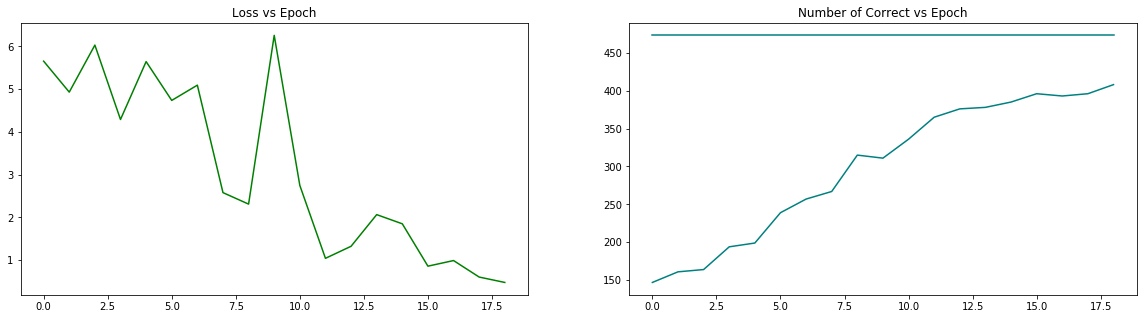

In [42]:
a=np.arange(19)
b=np.ones(19)*473
figs,axs=plt.subplots(1,2,figsize=(20,5))

axs[0].title.set_text('Loss vs Epoch')
axs[0].plot(a,epoch_loss_dat,color='g')

plt.title('Number of Correct vs Epoch')
axs[1].plot(a,b,epoch_num_correct,color='teal')
plt.show()

# Saving Models
The models can be saved and loaded in PyTorch as follows
- Save - save(model.state_dict(), 'PATH')

- Load-load_state_dict(torch.load('.PATH'))

In [43]:
torch.save(model.state_dict(), './MODEL_GD')
#model.load_state_dict(torch.load('./MODEL_GD'))

In [ ]:
torch.save(model_context.state_dict(),'./MODEL_CONTEXTGD')
#model_context.load_state_dict(torch.load('./MODEL_CONTEXTGD'))

# Validation Set

In [44]:
val_data_pd=pd.read_csv('./dataset/Val_data')
val_data_pd=val_data_pd.fillna(0)
#val_data_pd=val_data_pd.sample(frac=1)

In [45]:
val_data_pd.head()

,Unnamed: 0,idx,Title,Score,ID,Image,Num_Comments,Created,Body,Label1Coronovirus,Label2Politics,Label3Non-Political,Label4Objects,Label5AskIndia
0,0,0,Coronavirus (COVID-19) Megathread - News and U...,113,g1zi21,https://www.reddit.com/r/india/comments/g1zi21...,1214,1.587010e+09,###[Covid-19 Fundraisers & Donation Links](htt...,1,0,0,0,0
1,1,1,"Announcing r/IndiaMeme, our own sub for memes ...",282,fzub9j,https://www.reddit.com/r/india/comments/fzub9j...,86,1.586716e+09,HELLO YOU NICE PEOPLE. WE GOT REALLY TIRED OF ...,0,0,0,0,0
2,2,2,Different stages of hair loss in perfect order...,1674,g4200g,https://i.redd.it/ydbmwsa7jpt41.jpg,59,1.587302e+09,0,0,0,0,0,0
3,3,3,"#OnThisDay in 1975, history was made when Indi...",1029,g437kh,https://i.redd.it/8guugveh2qt41.jpg,29,1.587308e+09,0,0,0,0,0,0
4,4,4,All the 186 COVID-19 positive cases that were ...,349,g433q6,https://twitter.com/ANI/status/125176181030855...,53,1.587307e+09,0,1,0,0,0,0


In [46]:
title=list(val_data_pd['Title'])
body=list(val_data_pd['Body'])

scores=[]
labels=[]
for i in range(val_data_pd.shape[0]):
    scores.append((val_data_pd.loc[i,'Num_Comments'],val_data_pd.loc[i,'Score']))
    labels.append([val_data_pd.loc[i,'Label1Coronovirus'],val_data_pd.loc[i,'Label2Politics'],val_data_pd.loc[i,'Label3Non-Political'],val_data_pd.loc[i,'Label4Objects'],val_data_pd.loc[i,'Label5AskIndia']])

# Dataset Class
The dataset class for validation is mostly same apart from the fact that here the pretrained vocab is used instead of fitting one from scratch. For normal vectors loading doesnt require statedict as in the case of model weights

In [47]:
class Dataset(Dataset):
    def __init__(self,data_title,data_context,data_score,labels):
        
        #self.vectorizer=CountVectorizer()
        #self.vectorizer.fit_transform(data_context+data_title)
        vocab=torch.load('./vocab')
        self.token2idx=vocab
        
        self.sequences=[]
        self.sequences_context=[]
        for sent in data_title:
            sent_brok=[]
            
            for word in sent.split():
                try:
                
                    sent_brok.append(self.token2idx[word])
                except KeyError:
                    sent_brok.append('0')
            self.sequences.append(sent_brok)
        
        
        for sent in data_context:
            sent_brok=[]
            #print(sent)
            
            if sent==0:
                self.sequences_context.append(0)
                continue
            
            for word in sent.split():
                try:
                    sent_brok.append(self.token2idx[word])
                except KeyError:
                    sent_brok.append('0')
            self.sequences_context.append(sent_brok)
        #self.sequences_context=[self.token2idx[word] for word in data_context]
        self.score=data_score
        self.labels=labels
        self.idx2token={idx:token for token,idx in self.token2idx.items()}
        
    def __getitem__(self,i):
        return np.array(self.sequences[i],dtype=int),np.array(self.sequences_context[i],dtype=int),np.array(self.score[i],dtype=int),np.array(self.labels[i],dtype=int)
    
    def __len__(self):
        return len(self.sequences)

In [48]:
val_dataset=Dataset(data_title=title,data_context=body,data_score=scores,labels=labels)

In [49]:
def evaluate(model,model_context,valid_iter,val_data_len):
    running_loss=0.0
    
    model.eval()
    model_context.eval()
    epoch_lo=0
    for x,x_context,x2,y in tqdm.tqdm(valid_iter):
        
        x=torch.tensor(x).unsqueeze(0)
        x_context=torch.tensor(x_context).unsqueeze(0)
        x2=torch.tensor(x2).unsqueeze(0)
        y=torch.tensor(y)
        if(len(x_context.shape)==1):
            x_context=x_context.unsqueeze(0)
            
        context=model_context(x_context)
        
        
        #print(x.shape,x_context.shape,x2.shape)
        preds=model(data=x,num_data=x2.float(),context=context)
        
        preds=preds.squeeze(0)

        
        loss=criterion(preds.unsqueeze(0),torch.max(y,0)[1].unsqueeze(0))
        
        #print(torch.max(preds,0)[1])
        #print((torch.max(preds,0)[1]==torch.max(y,0)[1]))
        epoch_lo+=(torch.max(preds,0)[1]==torch.max(y,0)[1]).sum()
        #print(epoch_lo)
        running_loss+=loss.item()
    
    total_loss=running_loss/val_data_len
    print(f'Validation Loss: {total_loss}, Num_Correct={epoch_lo}')

In [50]:
evaluate(model,model_context,val_dataset,623)

  0%|          | 0/623 [00:00<?, ?it/s]/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 623/623 [00:07<00:00, 81.11it/s]

Validation Loss: 9.231143935326438, Num_Correct=98


In [ ]:
"""The embedding vector of covid before and after training"""

print(TEXT.vocab.vectors[395])
print(model.embedding.weight[395])

In [36]:
glove['corona']

array([ 0.77868  ,  0.18398  , -0.43352  ,  0.95954  , -0.72738  ,
       -0.9008   ,  0.32218  , -0.36436  ,  0.099159 ,  1.1266   ,
        0.39165  , -0.24366  , -0.079436 , -0.60457  ,  0.22274  ,
       -0.10854  , -0.84247  ,  0.96852  , -0.58184  , -0.45636  ,
       -0.7763   , -0.41435  ,  0.27486  , -0.06471  , -1.0923   ,
       -0.086898 , -0.0046549,  0.7083   , -0.56226  , -0.71986  ,
       -0.029976 , -0.78408  , -0.81421  , -0.5188   ,  0.87906  ,
       -0.68707  ,  0.23686  ,  0.27011  ,  0.48901  , -0.12128  ,
       -0.28702  , -0.19488  , -0.038685 , -0.28341  ,  0.28282  ,
        0.085235 ,  0.32122  , -1.3629   ,  0.054788 , -0.049236 ])

In [37]:
dataset.vectorizer.vocabulary_['corona']

1304

In [38]:
weight_matrix[1304]

array([ 0.59597  , -0.81011  , -0.18152  ,  0.54075  , -0.80682  ,
        0.48645  , -0.19321  , -0.65757  , -0.36665  ,  0.16266  ,
       -0.16876  ,  1.137    ,  0.16336  , -0.0070287,  0.042729 ,
        0.034256 ,  0.065436 ,  0.25122  , -0.15997  , -0.25737  ,
       -0.28178  ,  0.063979 ,  0.34702  ,  0.058471 ,  0.23484  ,
        0.34877  , -0.60567  , -0.45478  ,  0.16202  , -0.92028  ,
       -0.61519  , -0.51853  , -0.49749  ,  0.39104  ,  0.052879 ,
        0.024537 , -0.5303   , -0.90986  , -0.21012  , -0.4909   ,
       -0.046989 , -0.94025  ,  0.49622  ,  1.4761   ,  0.39893  ,
        0.47693  ,  0.27395  , -0.70441  , -0.27737  , -1.2093   ])